In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
# Drop unused columns
train = train.drop(columns=['Unnamed: 0', 'id'])
test = test.drop(columns=['Unnamed: 0', 'id'])

# Look at the first few rows
train.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             103904 non-null  object 
 1   Customer Type                      103904 non-null  object 
 2   Age                                103904 non-null  int64  
 3   Type of Travel                     103904 non-null  object 
 4   Class                              103904 non-null  object 
 5   Flight Distance                    103904 non-null  int64  
 6   Inflight wifi service              103904 non-null  int64  
 7   Departure/Arrival time convenient  103904 non-null  int64  
 8   Ease of Online booking             103904 non-null  int64  
 9   Gate location                      103904 non-null  int64  
 10  Food and drink                     103904 non-null  int64  
 11  Online boarding                    1039

Here is something very important. We can see that there are 5 object columns, which means we actually need to prepare the data in order to be able to analyze it. Also the 21. Col is a float64 which means increased precision.

### Info Analysis
All columns are complete except the 21. Arrival Delay in Minutes, which is missing 310 entries. Considering the total amount of entries being 103.904 it only accounts for 0.00298 percent. We will still remove it.

In [4]:
train.dropna(axis=0, inplace=True)

In [5]:
# Source - https://stackoverflow.com/a
# Posted by Walid
# Retrieved 2026-01-21, License - CC BY-SA 4.0
print(train['Gender'].value_counts())
print()
print(train['Customer Type'].value_counts())
print()
print(train['Type of Travel'].value_counts())
print()
print(train['Class'].value_counts())
print()
print(train['satisfaction'].value_counts())

Gender
Female    52576
Male      51018
Name: count, dtype: int64

Customer Type
Loyal Customer       84662
disloyal Customer    18932
Name: count, dtype: int64

Type of Travel
Business travel    71465
Personal Travel    32129
Name: count, dtype: int64

Class
Business    49533
Eco         46593
Eco Plus     7468
Name: count, dtype: int64

satisfaction
neutral or dissatisfied    58697
satisfied                  44897
Name: count, dtype: int64


In [6]:
mappings = {
    'Gender': {'Male': 1, 'Female': 0},
    'Customer Type': {'Loyal Customer': 1, 'disloyal Customer': 0},
    'Type of Travel': {'Business travel': 1, 'Personal Travel': 0},
    'Class': {'Business': 2, 'Eco Plus': 1, 'Eco': 0},
    'satisfaction': {'satisfied': 1, 'neutral or dissatisfied': 0}
}

train_mapped = train.copy()
for col, mapping in mappings.items():
    train_mapped[col] = train_mapped[col].map(mapping).fillna(-1).astype(int)

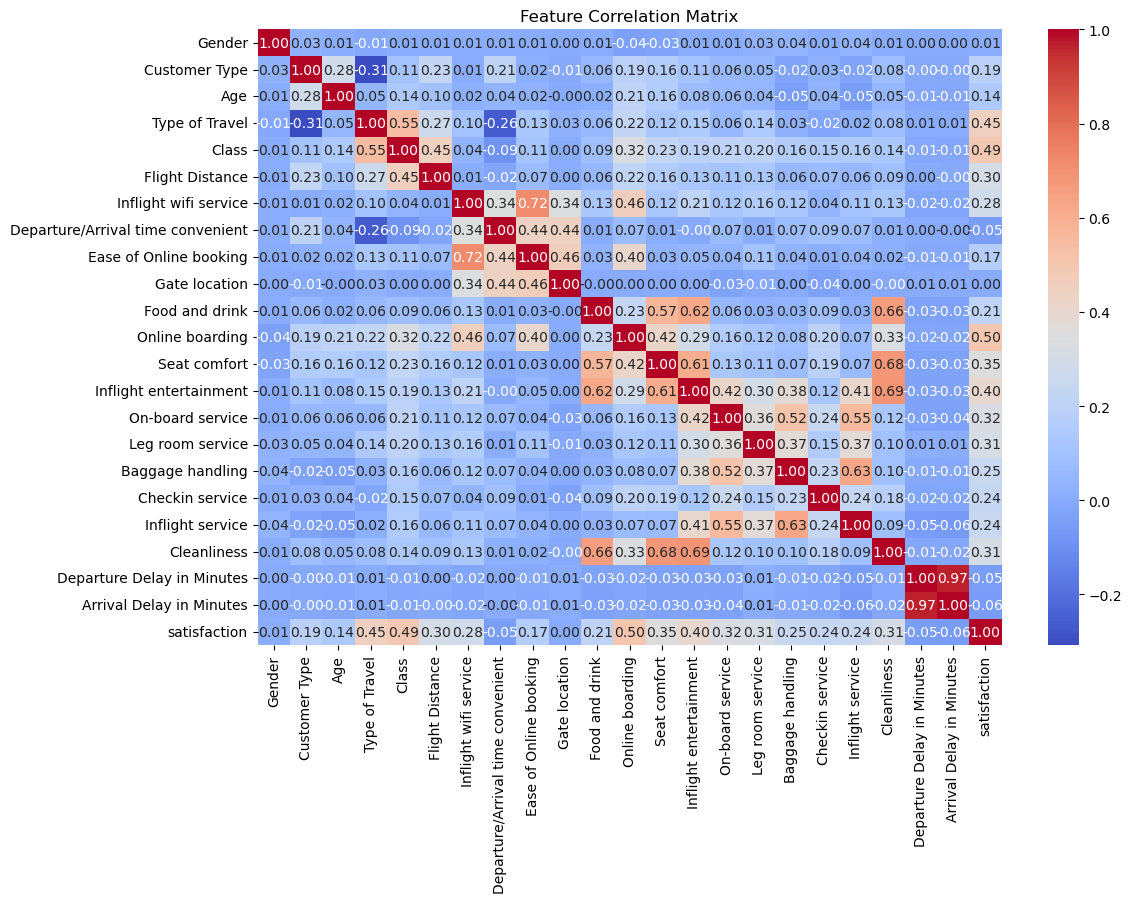

In [7]:
plt.figure(figsize=(12, 8))
# We only correlate numerical columns
correlation_matrix = train_mapped.select_dtypes(include=['number']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

### Correlations
The strongest correlations are of course **Departure Delay in Minutes** and **Arrival Delay in Minutes**, due to the fact of them having a clear causality. The more you delay your start, the later you arrive at your destination - which is quite annoying for most people.

The most important thing to keep in mind is that the dataset comes from a survey conducted by the airline
Gate Location correlates with the following: **Inflight wifi service**, **Departure/Arrival time convenient**, **Ease of Online booking**
None the less we couldn't find any casaul connection to these cols.

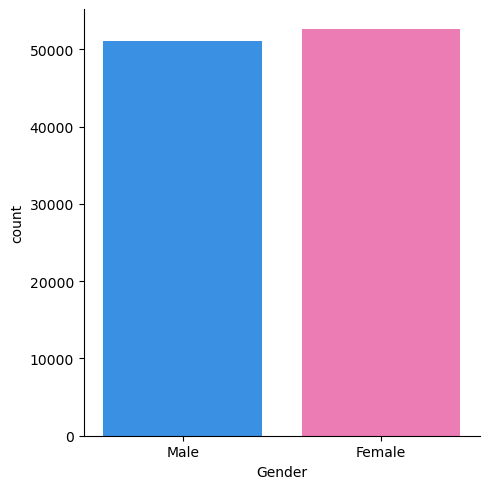

In [8]:
sns.catplot(x="Gender", kind="count", data=train, hue='Gender', palette={"Female": "hotpink", "Male": "dodgerblue"})

The dataset seems pretty evenly balanced out on gender.

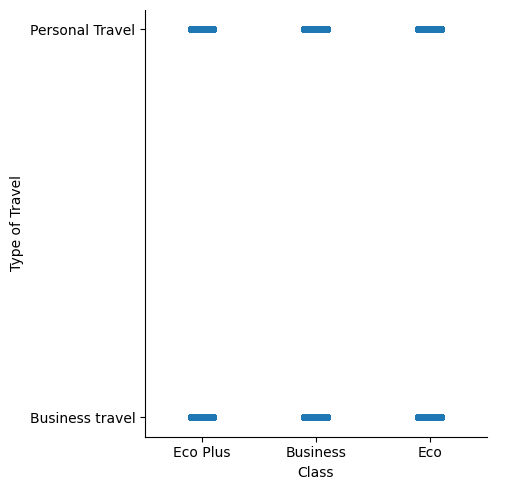

In [9]:
sns.catplot(data=train, x="Class", y="Type of Travel")

idk what the plan was for this plot 💀

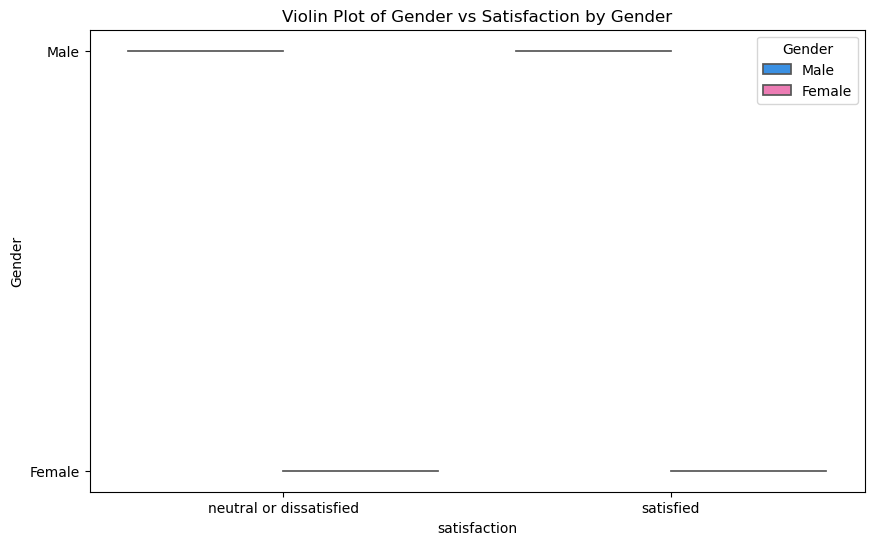

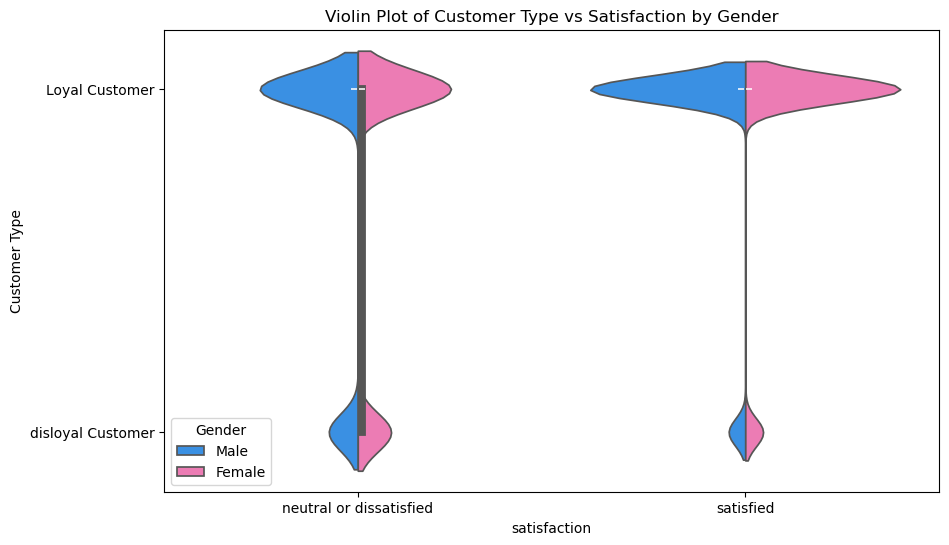

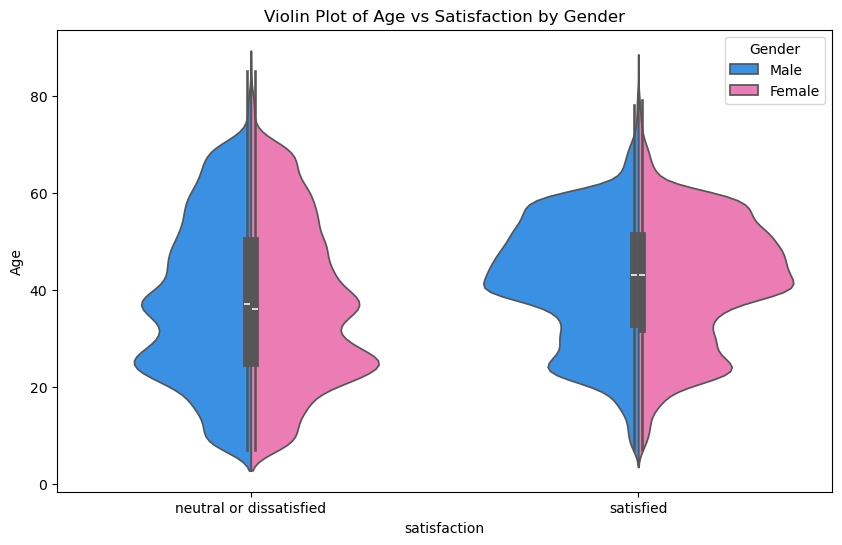

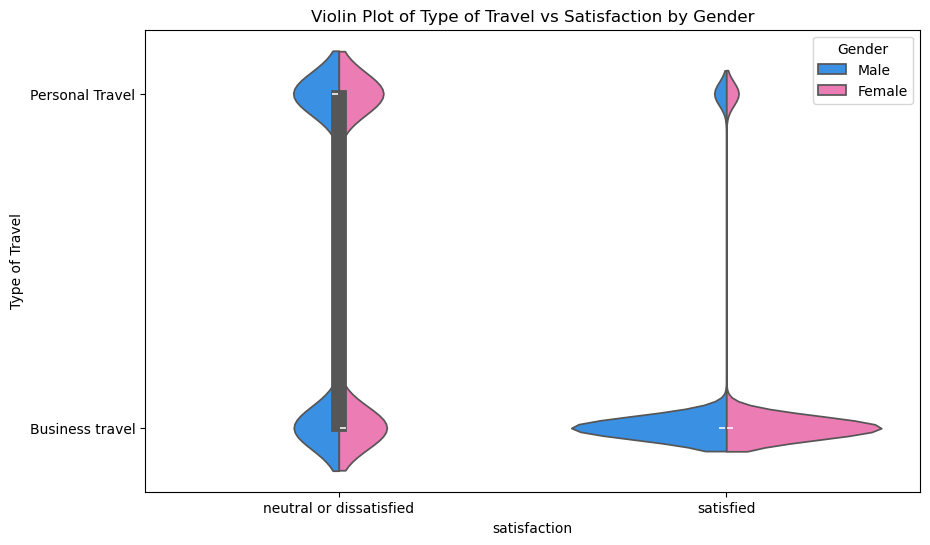

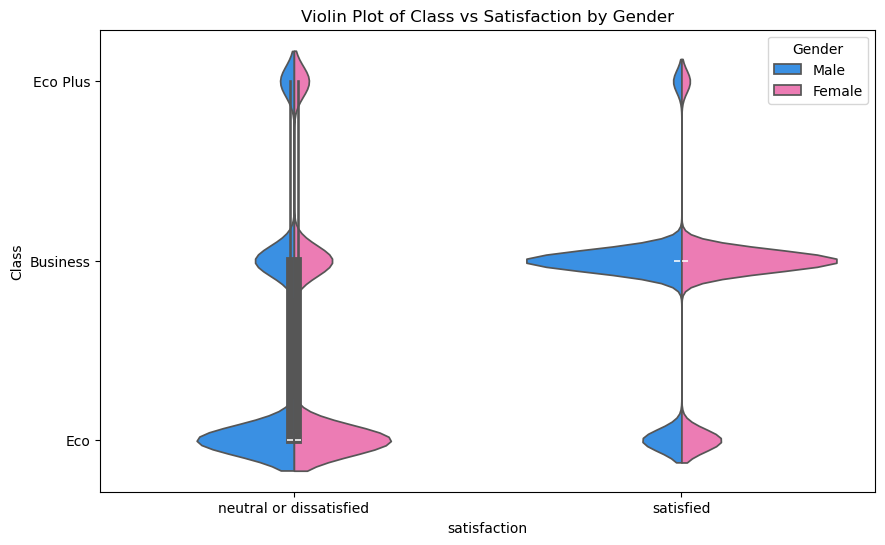

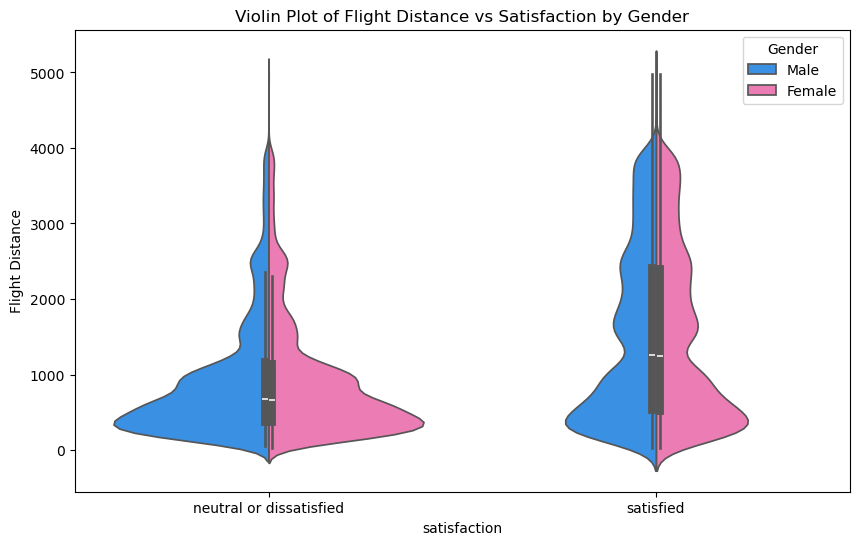

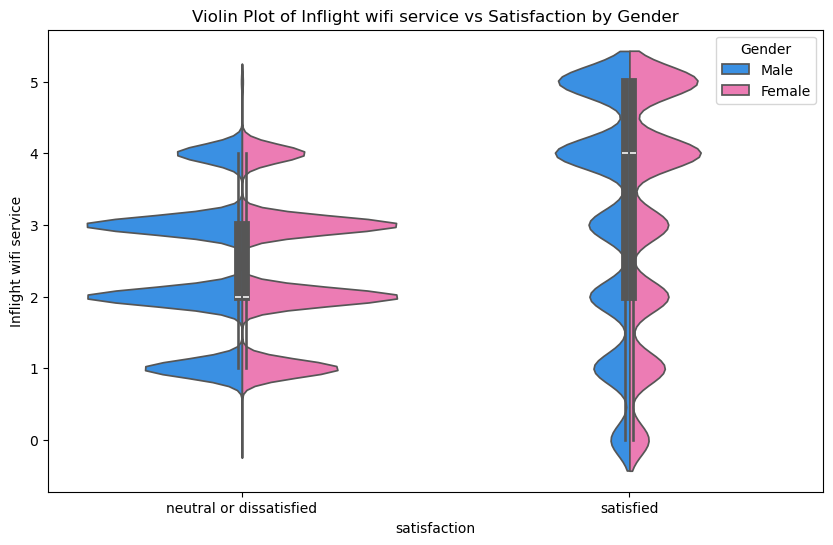

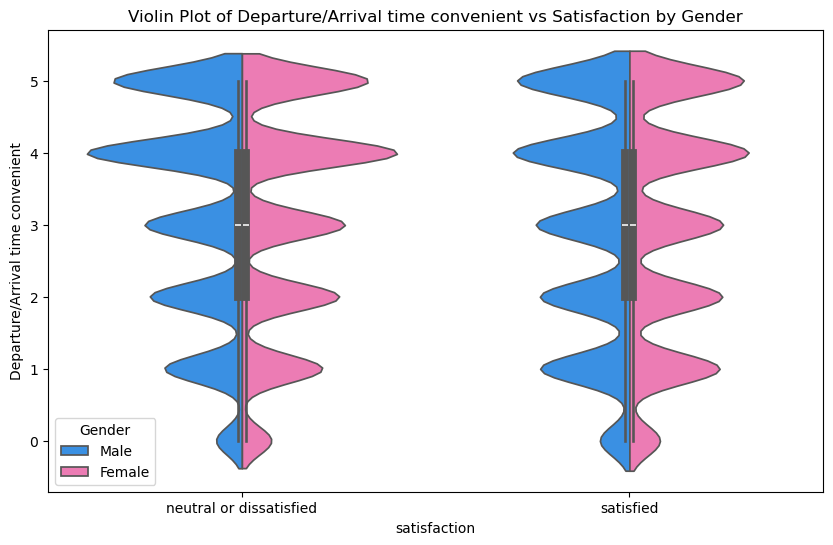

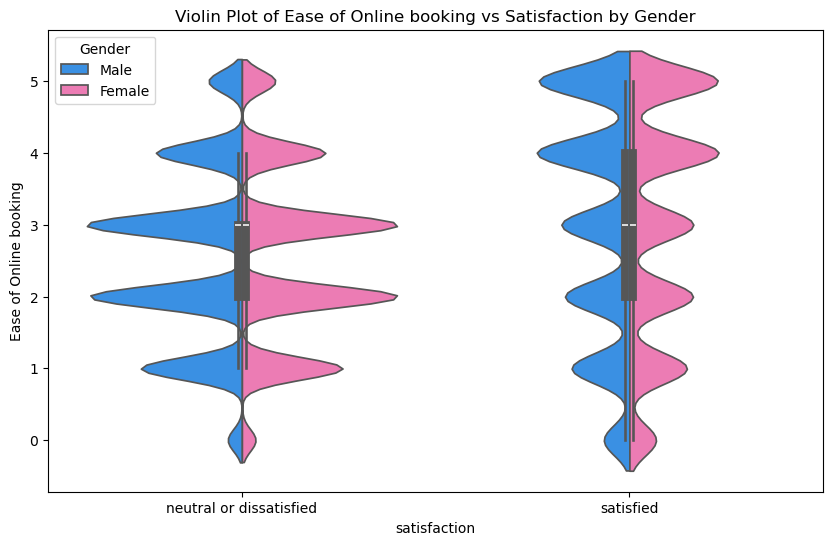

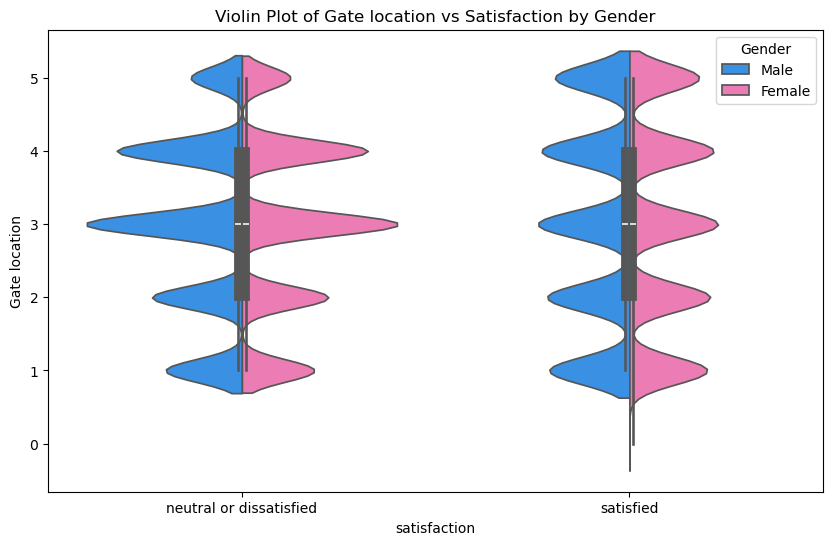

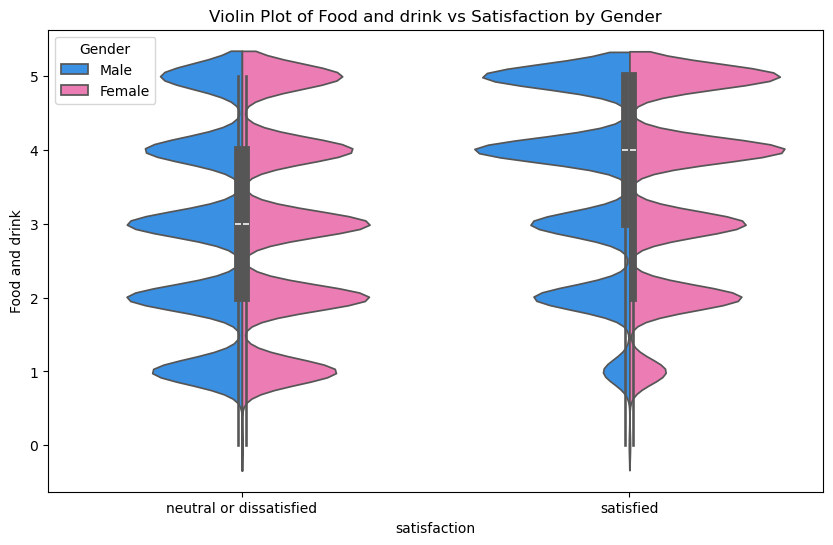

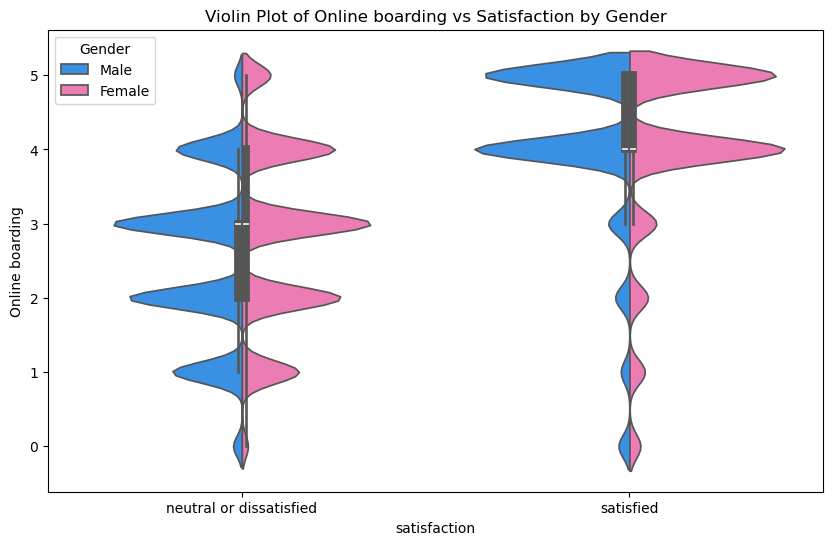

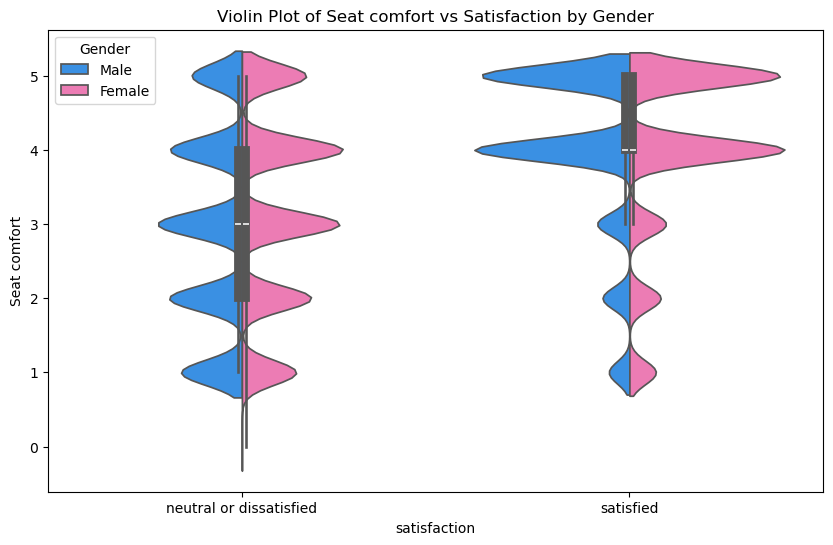

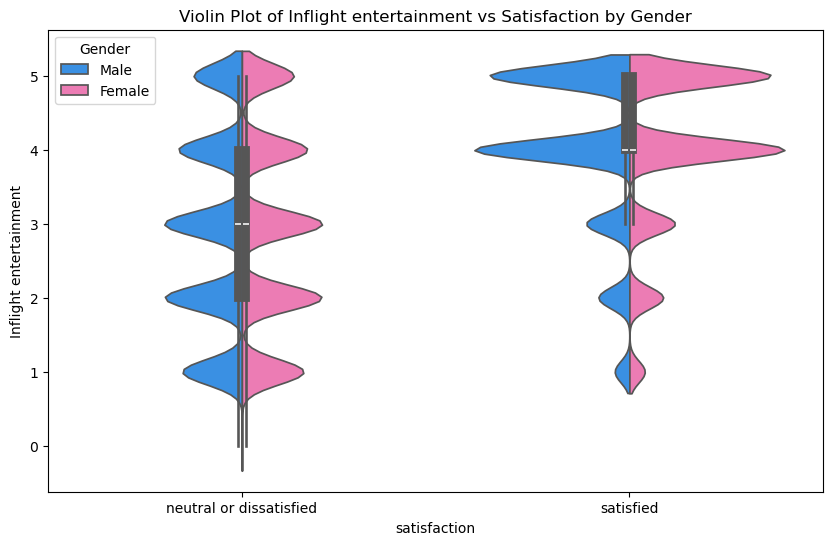

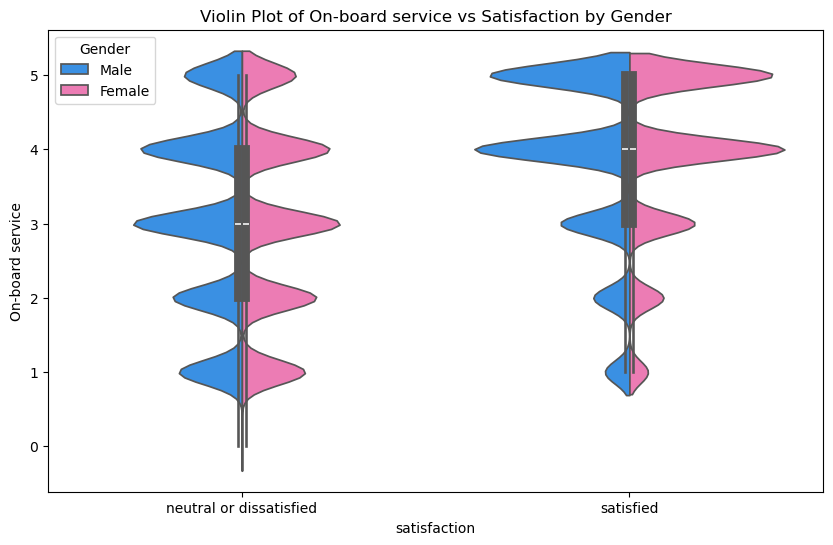

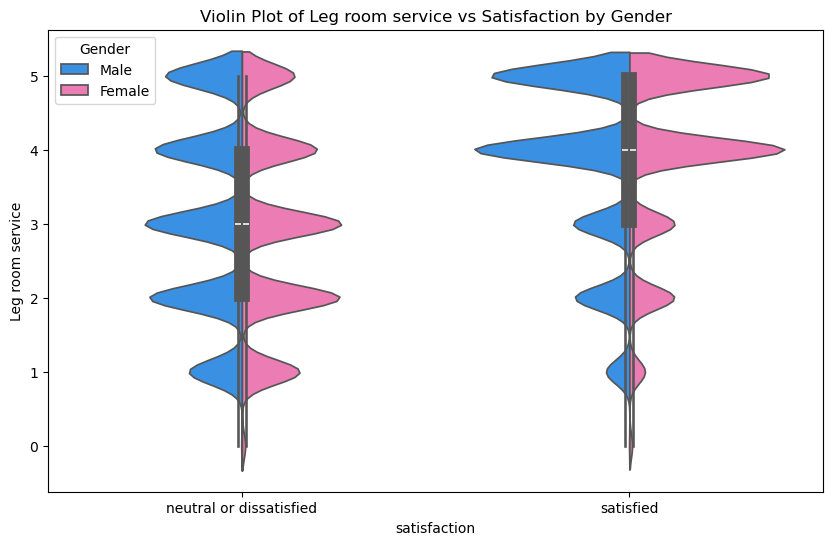

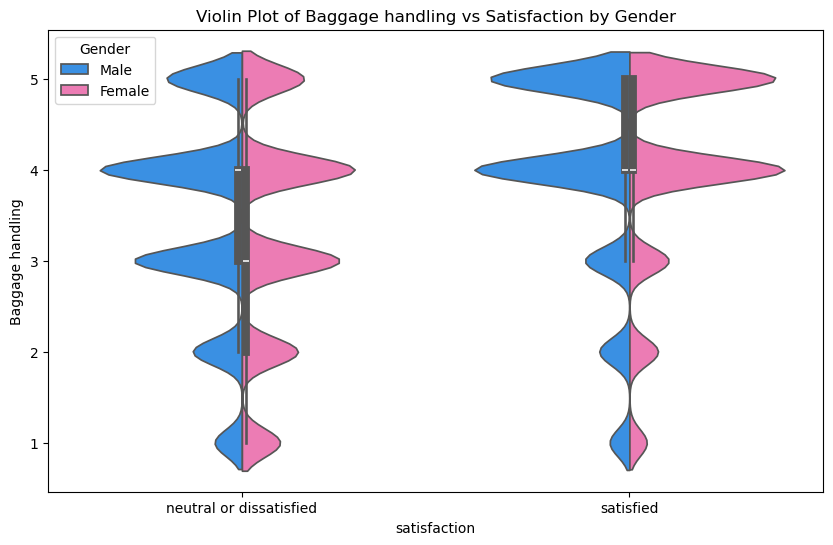

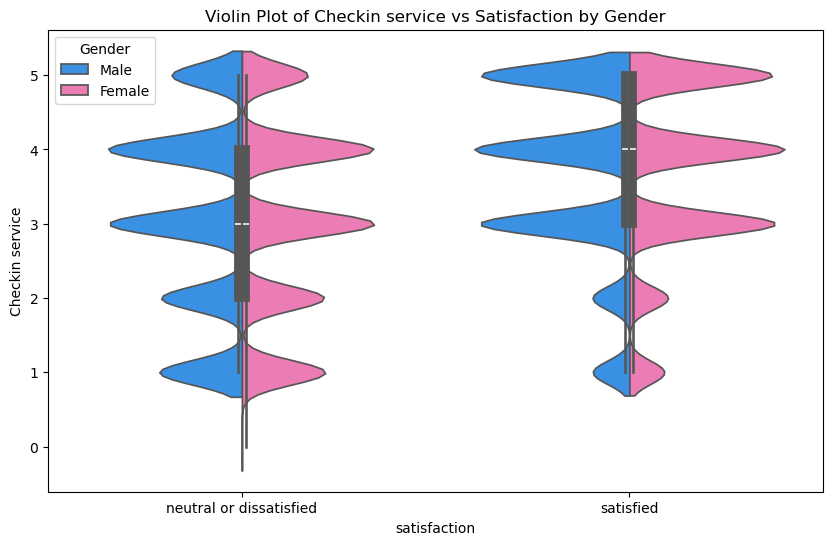

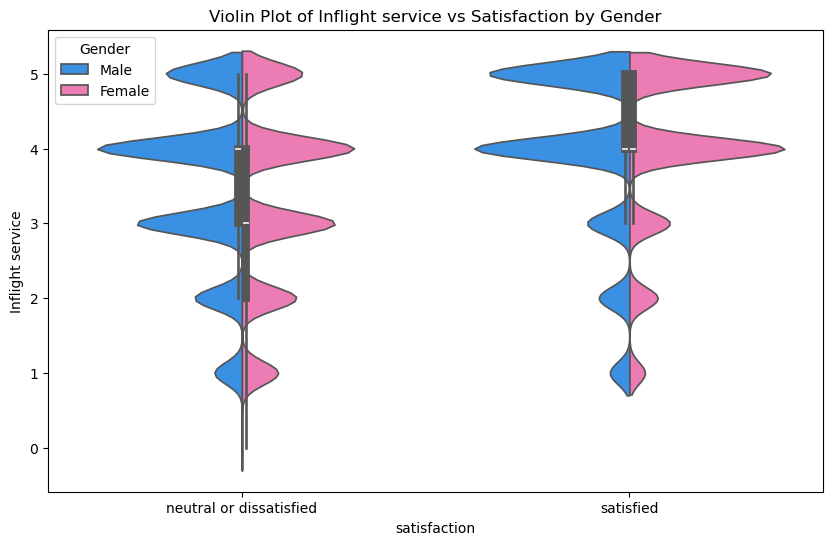

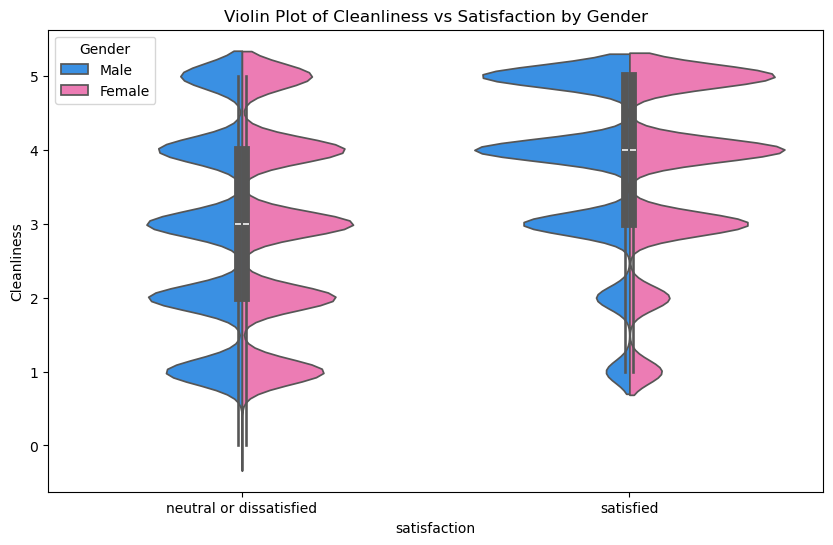

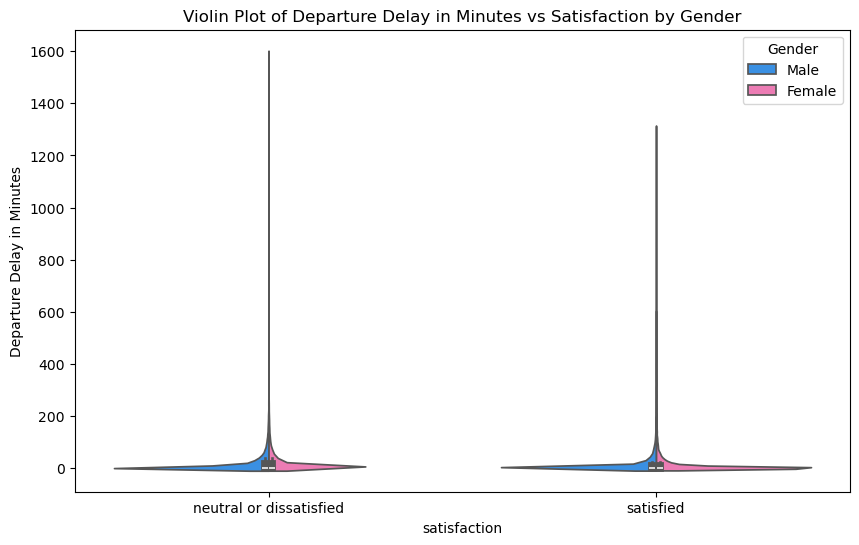

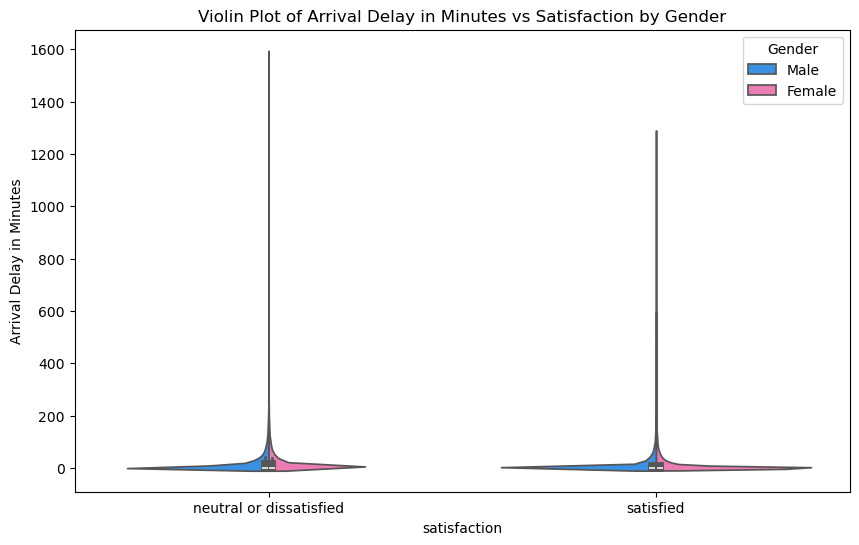

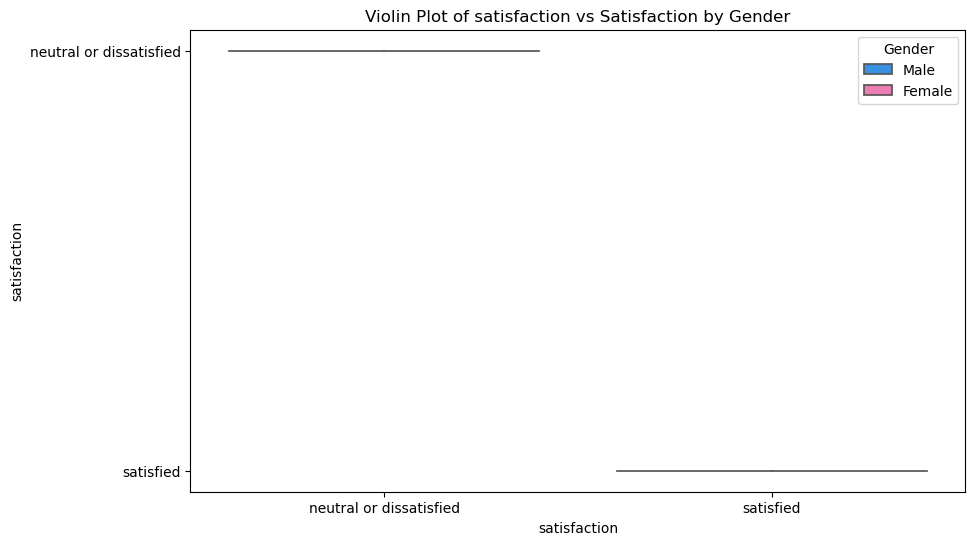

In [10]:
for feature in train:
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=train.replace({"Gender": {0: "Female", 1: "Male"}}), x='satisfaction', y=feature, hue='Gender', split=True, palette={"Female": "hotpink", "Male": "dodgerblue"})
    plt.title(f'Violin Plot of {feature} vs Satisfaction by Gender')
    plt.show()

We get a lot of plots to look for correlations specific to gender. However, there doesnt really seem to be a difference between genders at all. The closest we get is that for online boarding, more females decided to give 5 stars, while remaining neutral or dissatisfied overall.

## Satisfaction Drivers

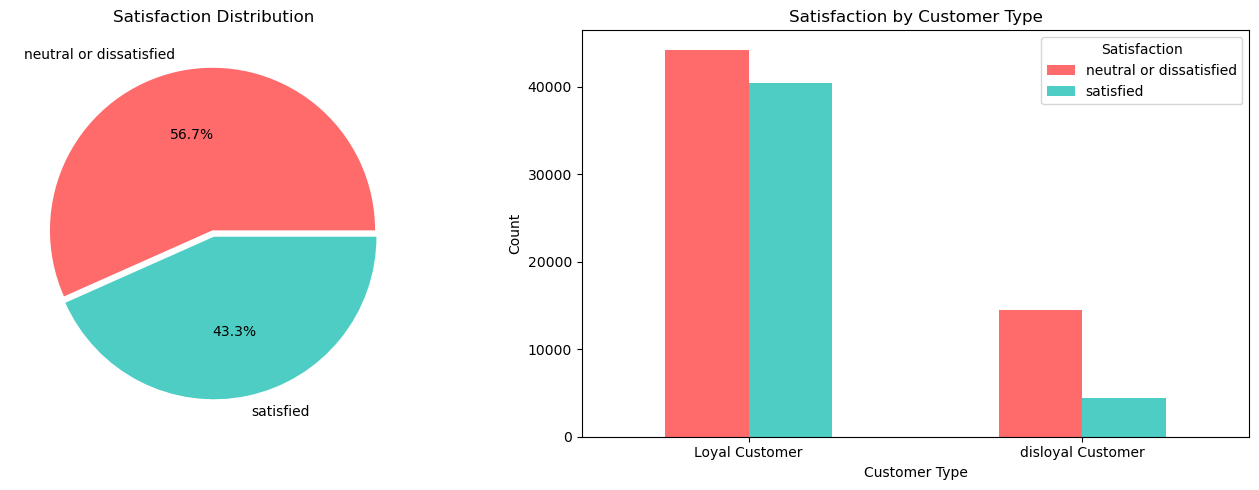

In [11]:
# 1. Target Variable Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Satisfaction counts
satisfaction_counts = train['satisfaction'].value_counts()
axes[0].pie(satisfaction_counts, labels=satisfaction_counts.index, autopct='%1.1f%%', 
            colors=['#ff6b6b', '#4ecdc4'], explode=(0.02, 0.02))
axes[0].set_title('Satisfaction Distribution')

# Satisfaction by Customer Type
satisfaction_by_customer = train.groupby(['Customer Type', 'satisfaction']).size().unstack(fill_value=0)
satisfaction_by_customer.plot(kind='bar', ax=axes[1], color=['#ff6b6b', '#4ecdc4'])
axes[1].set_title('Satisfaction by Customer Type')
axes[1].set_xlabel('Customer Type')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=0)
axes[1].legend(title='Satisfaction')

plt.tight_layout()
plt.show()

Here we can see that loyal customers still tend to be slightly more neutral/dissatisfied than satisfied. However, the difference is not as big as for disloyal customers.

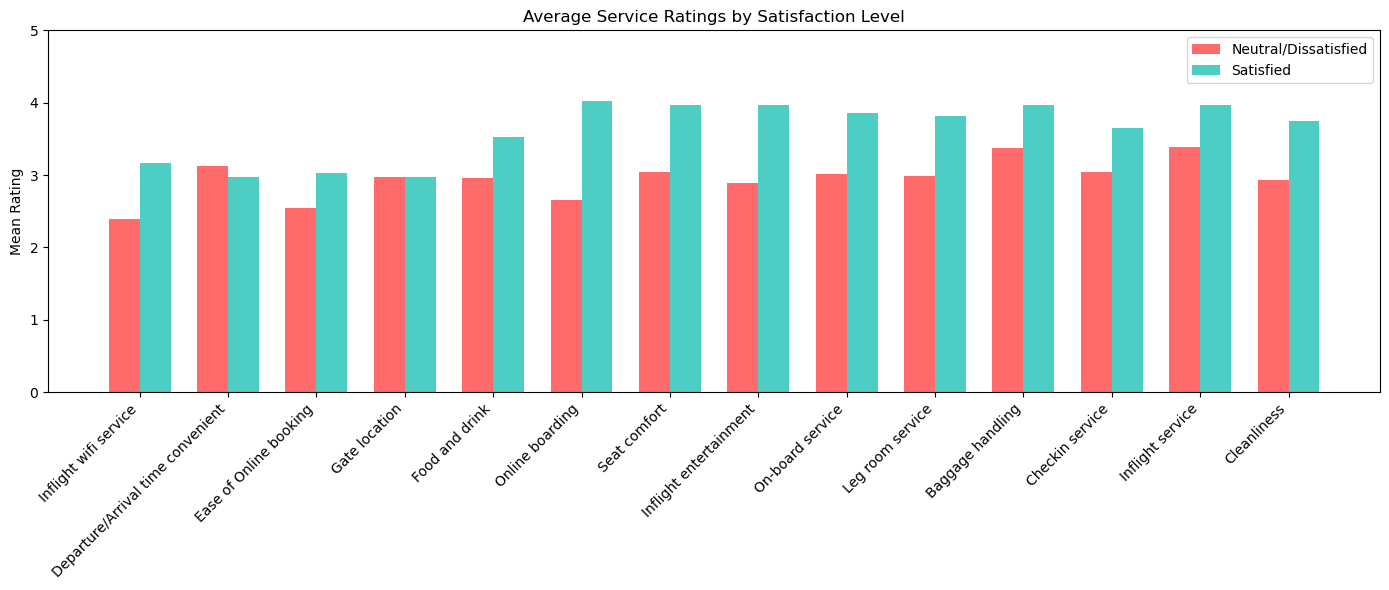


Rating difference (Satisfied - Dissatisfied):
Online boarding                      1.37
Inflight entertainment               1.07
Seat comfort                         0.93
On-board service                     0.84
Leg room service                     0.83
Cleanliness                          0.81
Inflight wifi service                0.76
Checkin service                      0.60
Baggage handling                     0.59
Inflight service                     0.58
Food and drink                       0.56
Ease of Online booking               0.48
Gate location                        0.00
Departure/Arrival time convenient   -0.16
dtype: float64


In [12]:
# 2. Service Ratings Comparison: Satisfied vs Dissatisfied
service_cols = ['Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking',
                'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
                'Inflight entertainment', 'On-board service', 'Leg room service',
                'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness']

# Calculate mean ratings by satisfaction
service_means = train.groupby('satisfaction')[service_cols].mean()

fig, ax = plt.subplots(figsize=(14, 6))
x = range(len(service_cols))
width = 0.35

bars1 = ax.bar([i - width/2 for i in x], service_means.loc['neutral or dissatisfied'], 
               width, label='Neutral/Dissatisfied', color='#ff6b6b')
bars2 = ax.bar([i + width/2 for i in x], service_means.loc['satisfied'], 
               width, label='Satisfied', color='#4ecdc4')

ax.set_ylabel('Mean Rating')
ax.set_title('Average Service Ratings by Satisfaction Level')
ax.set_xticks(x)
ax.set_xticklabels(service_cols, rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 5)

plt.tight_layout()
plt.show()

# Print the difference
diff = service_means.loc['satisfied'] - service_means.loc['neutral or dissatisfied']
print("\nRating difference (Satisfied - Dissatisfied):")
print(diff.sort_values(ascending=False).round(2))

The bar chart highlights substantial rating gaps between satisfied and neutral/dissatisfied passengers, with the key factors being **online boarding, inflight entertainment, seat comfort, on-board service, leg room, and cleanliness** (all > 0.8), indicating these as primary satisfaction drivers. In contrast, **gate location** and **departure/arrival time convenience** show negligible separation, contributing little predictive power and can most likely be deprioritized.

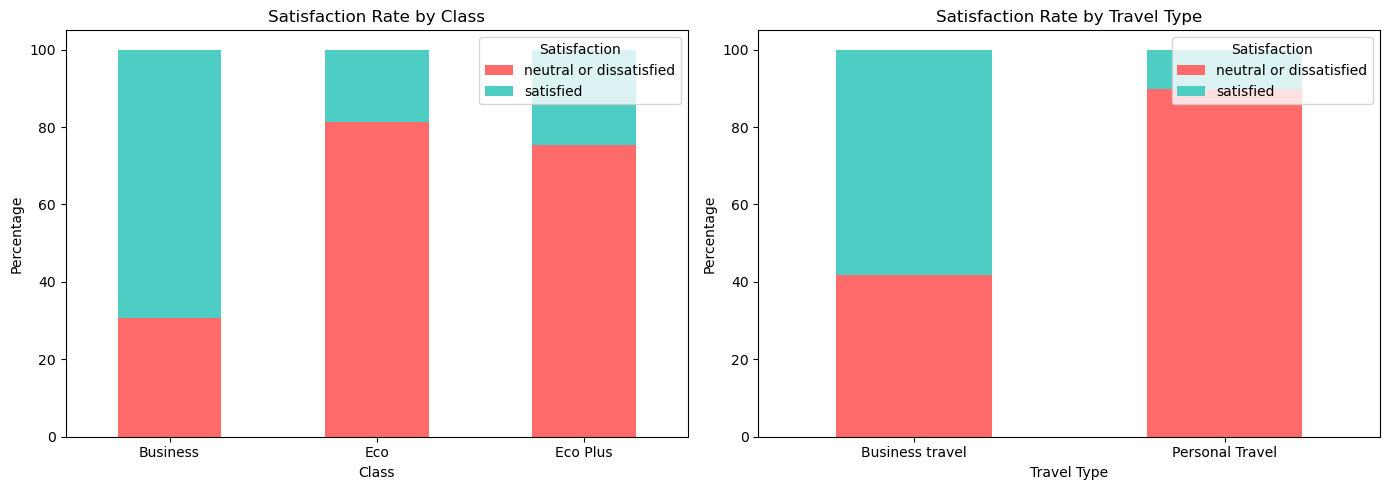

Satisfaction rates:
Business Class: 69.4%
Eco Plus: 24.6%
Eco: 18.6%


In [13]:
# 3. Satisfaction by Class and Travel Type
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# By Class
class_sat = train.groupby(['Class', 'satisfaction']).size().unstack(fill_value=0)
class_sat_pct = class_sat.div(class_sat.sum(axis=1), axis=0) * 100
class_sat_pct.plot(kind='bar', stacked=True, ax=axes[0], color=['#ff6b6b', '#4ecdc4'])
axes[0].set_title('Satisfaction Rate by Class')
axes[0].set_ylabel('Percentage')
axes[0].set_xlabel('Class')
axes[0].tick_params(axis='x', rotation=0)
axes[0].legend(title='Satisfaction', loc='upper right')

# By Travel Type
travel_sat = train.groupby(['Type of Travel', 'satisfaction']).size().unstack(fill_value=0)
travel_sat_pct = travel_sat.div(travel_sat.sum(axis=1), axis=0) * 100
travel_sat_pct.plot(kind='bar', stacked=True, ax=axes[1], color=['#ff6b6b', '#4ecdc4'])
axes[1].set_title('Satisfaction Rate by Travel Type')
axes[1].set_ylabel('Percentage')
axes[1].set_xlabel('Travel Type')
axes[1].tick_params(axis='x', rotation=0)
axes[1].legend(title='Satisfaction', loc='upper right')

plt.tight_layout()
plt.show()

print("Satisfaction rates:")
print(f"Business Class: {class_sat_pct.loc['Business', 'satisfied']:.1f}%")
print(f"Eco Plus: {class_sat_pct.loc['Eco Plus', 'satisfied']:.1f}%")
print(f"Eco: {class_sat_pct.loc['Eco', 'satisfied']:.1f}%")

C:\Users\Deniz\AppData\Local\Temp\ipykernel_26416\2692535512.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  delay_sat = train.groupby(['Delay Category', 'satisfaction']).size().unstack(fill_value=0)


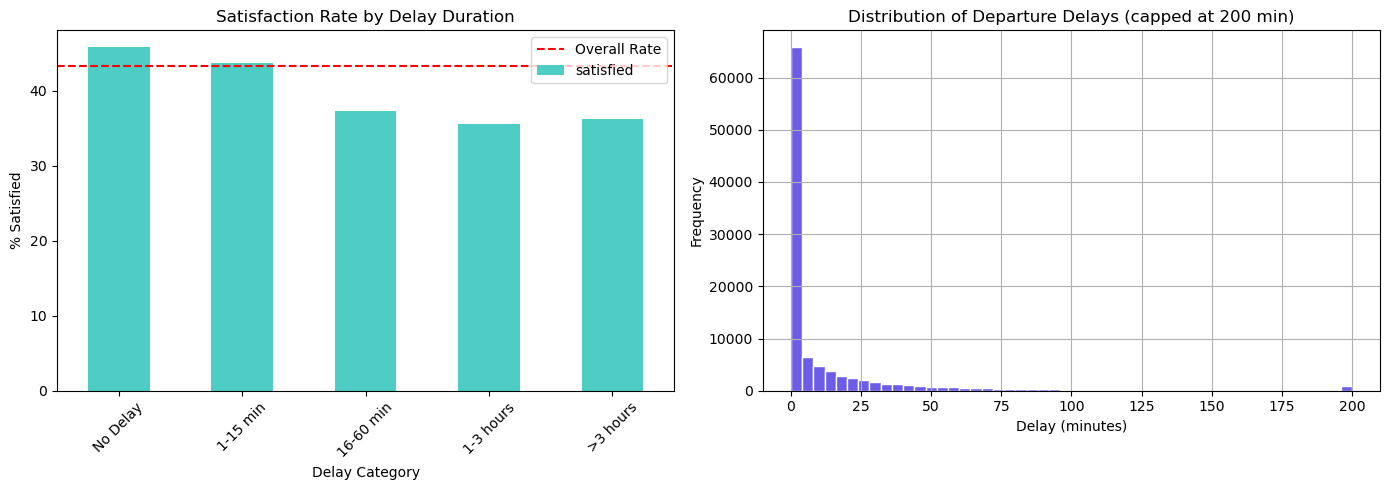

In [14]:
# 4. Delay Impact Analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Create delay bins
train['Delay Category'] = pd.cut(train['Departure Delay in Minutes'], 
                                  bins=[-1, 0, 15, 60, 180, float('inf')],
                                  labels=['No Delay', '1-15 min', '16-60 min', '1-3 hours', '>3 hours'])

# Satisfaction by delay category
delay_sat = train.groupby(['Delay Category', 'satisfaction']).size().unstack(fill_value=0)
delay_sat_pct = delay_sat.div(delay_sat.sum(axis=1), axis=0) * 100

delay_sat_pct['satisfied'].plot(kind='bar', ax=axes[0], color='#4ecdc4')
axes[0].set_title('Satisfaction Rate by Delay Duration')
axes[0].set_ylabel('% Satisfied')
axes[0].set_xlabel('Delay Category')
axes[0].tick_params(axis='x', rotation=45)
axes[0].axhline(y=train['satisfaction'].value_counts(normalize=True)['satisfied']*100, 
                color='red', linestyle='--', label='Overall Rate')
axes[0].legend()

# Distribution of delays
train['Departure Delay in Minutes'].clip(upper=200).hist(bins=50, ax=axes[1], color='#6c5ce7', edgecolor='white')
axes[1].set_title('Distribution of Departure Delays (capped at 200 min)')
axes[1].set_xlabel('Delay (minutes)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Clean up temp column
train.drop('Delay Category', axis=1, inplace=True)

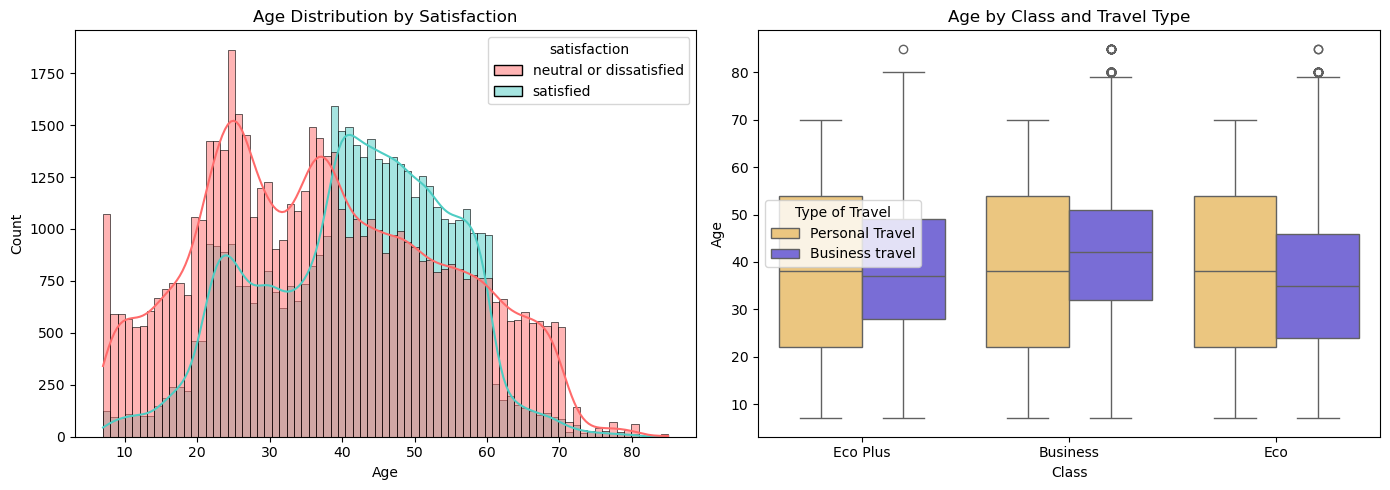


Mean age analysis:
Type of Travel   satisfaction           
Business travel  neutral or dissatisfied    36.8
                 satisfied                  42.1
Personal Travel  neutral or dissatisfied    38.3
                 satisfied                  37.9
Name: Age, dtype: float64


In [15]:
# 5. Age Distribution Analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Age distribution by satisfaction
sns.histplot(data=train, x='Age', hue='satisfaction', kde=True, ax=axes[0], 
             palette={'satisfied': '#4ecdc4', 'neutral or dissatisfied': '#ff6b6b'})
axes[0].set_title('Age Distribution by Satisfaction')

# Age distribution by travel type and class
sns.boxplot(data=train, x='Class', y='Age', hue='Type of Travel', ax=axes[1],
            palette={'Business travel': '#6c5ce7', 'Personal Travel': '#fdcb6e'})
axes[1].set_title('Age by Class and Travel Type')

plt.tight_layout()
plt.show()

# Key insight
print("\nMean age analysis:")
print(train.groupby(['Type of Travel', 'satisfaction'])['Age'].mean().round(1))

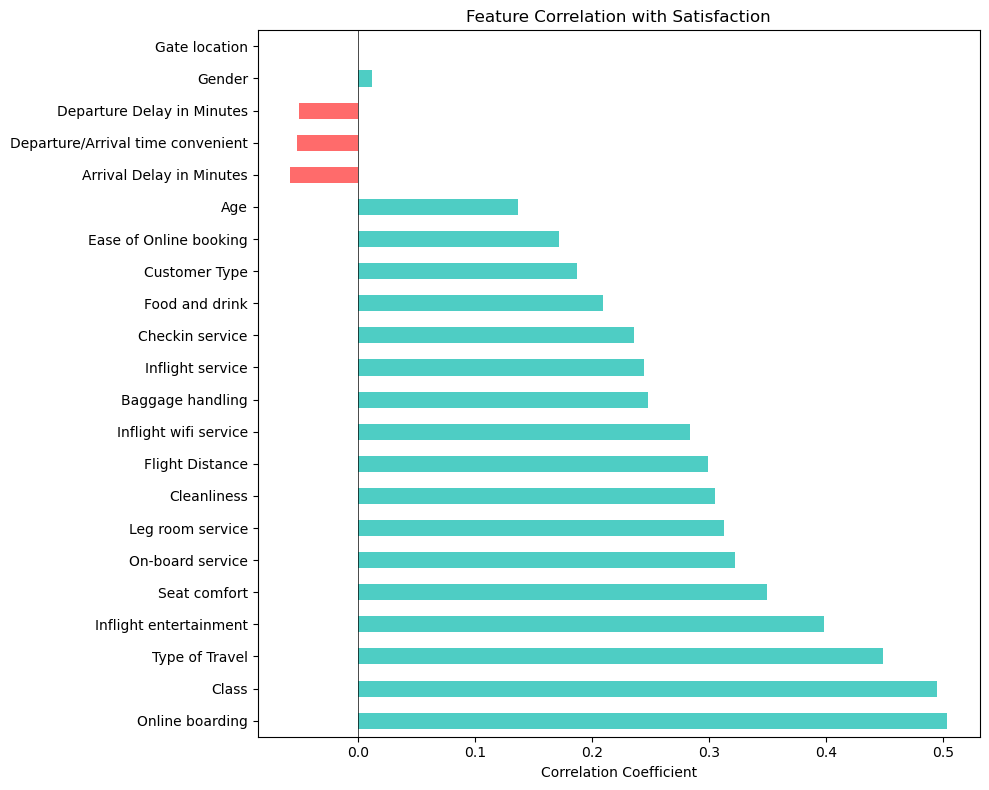


Top 5 positive correlations:
Online boarding           0.503
Class                     0.495
Type of Travel            0.449
Inflight entertainment    0.398
Seat comfort              0.349
Name: satisfaction, dtype: float64

Top 5 negative correlations:
Arrival Delay in Minutes            -0.058
Departure/Arrival time convenient   -0.052
Departure Delay in Minutes          -0.051
Gender                               0.012
Gate location                        0.000
Name: satisfaction, dtype: float64


In [16]:
# 6. Feature Importance (Correlation with Satisfaction)
# Using the mapped dataset for correlation analysis
satisfaction_corr = train_mapped.corr()['satisfaction'].drop('satisfaction').sort_values(key=abs, ascending=False)

plt.figure(figsize=(10, 8))
colors = ['#4ecdc4' if x > 0 else '#ff6b6b' for x in satisfaction_corr]
satisfaction_corr.plot(kind='barh', color=colors)
plt.title('Feature Correlation with Satisfaction')
plt.xlabel('Correlation Coefficient')
plt.axvline(x=0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()

print("\nTop 5 positive correlations:")
print(satisfaction_corr.head().round(3))
print("\nTop 5 negative correlations:")
print(satisfaction_corr.tail().round(3))